In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')



In [3]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

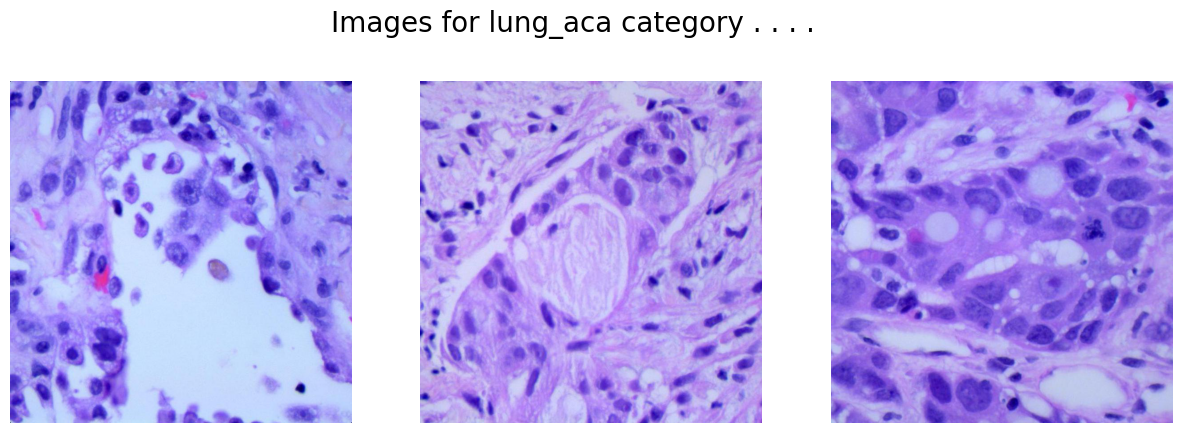

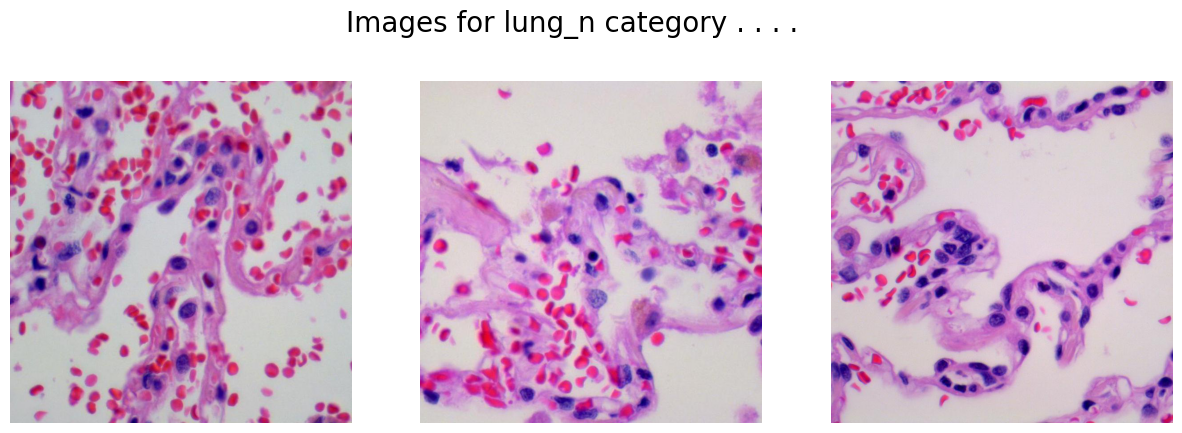

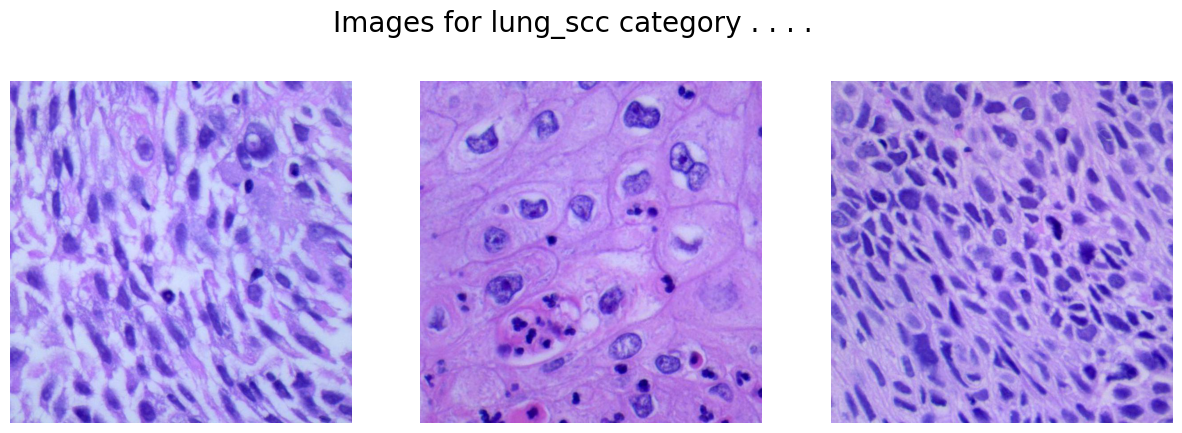

In [5]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [6]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [11]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                test_size = SPLIT,
                                                random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [13]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,IMG_SIZE,3),
                  padding='same'),layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                kernel_size=(3, 3),
                activation='relu',
                padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                kernel_size=(3, 3),
                activation='relu',
                padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])


2023-03-20 11:46:42.031346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

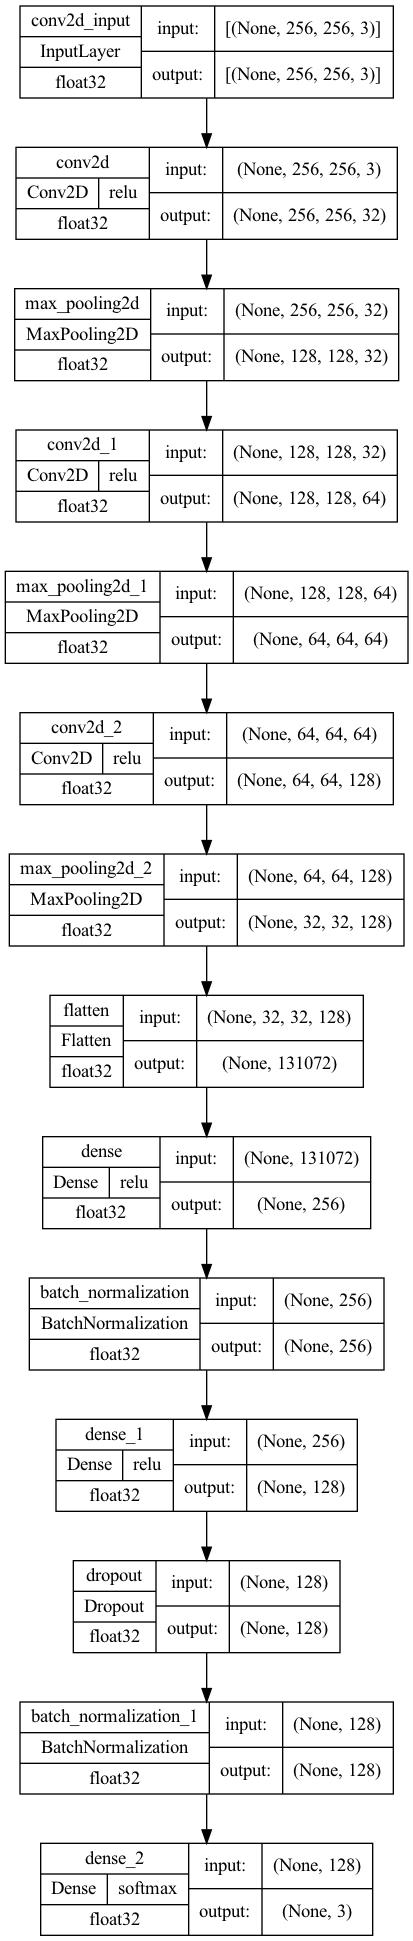

In [15]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)


In [16]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [18]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallbac


Epoch 1/10
188/188 [==============================] - 1425s 8s/step - loss: 0.3707 - accuracy: 0.8468 - val_loss: 3.1150 - val_accuracy: 0.4277 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 1687s 9s/step - loss: 0.2308 - accuracy: 0.9078 - val_loss: 1.9796 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 1259s 7s/step - loss: 0.1840 - accuracy: 0.9256 - val_loss: 2.2008 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 1301s 7s/step - loss: 0.1338 - accuracy: 0.9474 - val_loss: 0.8833 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 1414s 8s/step - loss: 0.1094 - accuracy: 0.9577 - val_loss: 4.0637 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9698
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 

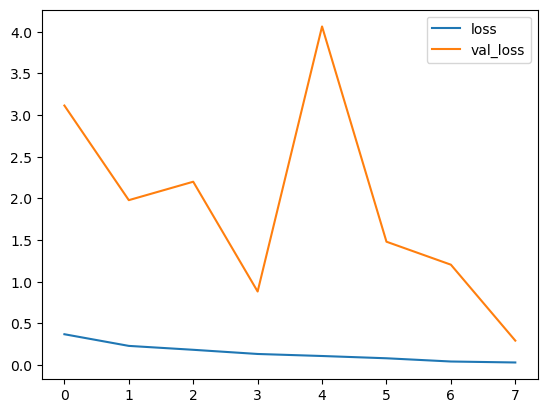

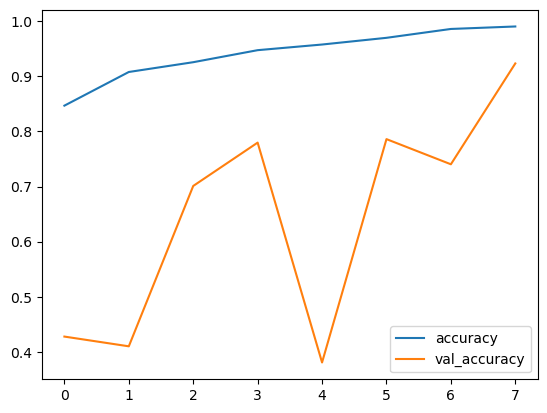

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [20]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 93s 958ms/step


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[927,   0,  60],
       [ 65, 912,   0],
       [105,   0, 931]])

In [23]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.85      0.94      0.89       987
      lung_n       1.00      0.93      0.97       977
    lung_scc       0.94      0.90      0.92      1036

    accuracy                           0.92      3000
   macro avg       0.93      0.92      0.92      3000
weighted avg       0.93      0.92      0.92      3000

